### Load required libraries

In [1]:
import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
# import seaborn as sns
# sns.set_context('poster')
# sns.set_style('white')

import numpy as np
from __future__ import division
import scipy.stats as stats

import pandas as pd
import json
import re

from PIL import Image
import base64

import seaborn as sns
from glob import glob

from scipy.spatial import distance

### Load VGG feature analysis libraries and scripts

In [2]:
import torch
import torchvision.models as models
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable

import scipy.stats as stats
from scipy.stats import norm
# import sklearn
# from sklearn.model_selection import train_test_split, cross_val_score
# from sklearn import svm
# from sklearn import linear_model, datasets, neighbors

from sklearn.cluster import AffinityPropagation
# from sklearn import metrics

from glob import glob
import os

import embedding as emb
reload(emb)
from embedding import *

In [3]:
# Retrieve sketch paths -- pngs rendered out in another step
def list_files(path, ext='png'):
    result = [y for x in os.walk(path) for y in glob(os.path.join(x[0], '*.%s' % ext))]
    return result

# extract metadata
path_to_sketches = 'museumstation_sketches'
sketch_paths = sorted(list_files(path_to_sketches))

## number of sketch paths 
print 'Number of sketch paths = {} before filtering'.format(len(sketch_paths))
png_sketch_count = len(sketch_paths)



Number of sketch paths = 8037 before filtering


## extract features

**Dec 28 2017 (updated Jan 14 2018):** <br>
 - From command line, extract features using `extract_features.py`. The default arguments are for the kid's drawings. <br>
 - To extract kid's drawings, just run: `python extract_features.py` <br>
 - To extract (mini verison of) adult drawings, run: `python extract_features.py --data='/data2/jefan/quickDraw/png_mini' --layer_ind=6 --cohort='adult' --spatial_avg=True`

In [142]:
# z-score normalization to "center" the sketch embeddings
def normalize(X):
    X = X - X.mean(0)
    X = X / np.maximum(X.std(0), 1e-5)
    return X

def get_class_means(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    X = normalize(X)
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def get_class_means_not_normalized(X, labels):    
    # load in and normalize features 
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

def normalize_RDM(MAT):
    X = MAT - MAT.mean(0).mean(0)
    X = X / np.maximum(MAT.std(0).std(0), 1e-5)
    return X

def plot_rdm_by_class(Features,X,layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']        
    sns.set_style('white')
    fig = plt.figure(figsize=(6,6))
    labels = X.label.values
    means = get_class_means(Features, labels)
    CORRMAT = np.corrcoef(means)
    plt.matshow(CORRMAT)
    plt.colorbar()
    if not os.path.exists('./plots'):
        os.makedirs('./plots')
    plt.savefig('./plots/RDM_by_view_{}.pdf'.format(layers[layer_num]))
    
def load_features(cohort, layer_num):
    layers = ['P1','P2','P3','P4','P5','FC6','FC7']    
    F = np.load('museumstation_features/FEATURES_{}_{}_Spatial_True.npy'.format(layers[layer_num],cohort))
    M = pd.read_csv('museumstation_features/METADATA_{}.csv'.format(cohort)) 
#     F = np.load('/data/old_home/bria/kiddraw/data/museumstation_features/FEATURES_{}_{}_Spatial_True.npy'.format(layers[layer_num],cohort))
#     M = pd.read_csv('/data/old_home/bria/kiddraw/data/museumstation_features/METADATA_{}.csv'.format(cohort)) 
    
    M = M[['label','age','session']]
    return F, M

def remove_practice_trials(KF,KM):
    '''
    remove "circle" and "triangle" trials from dataset
    '''
    practice_objects = ['circle','triangle']
    _KF = KF[~KM['label'].isin(practice_objects),:]
    _KM = KM[~KM['label'].isin(practice_objects)]
    return _KF, _KM

def flatten(x):
    return [item for sublist in x for item in sublist]


In [143]:
## CHOOSE LAYER IND FOR PLOTTING RDMS ETC
layer_ind = 6

## load in kid features
KF, KM = load_features('kid',layer_ind)
KF, KM = remove_practice_trials(KF, KM)
KM = KM.reset_index(drop=True)

print 'Number of unique kids who contributed drawings = {}'.format(np.size(np.unique(KM['session'].values)))
print 'Number of features for {} images in layer {} = {}'.format(np.shape(KF)[0], layer_ind, np.shape(KF)[1])
feature_sketch_count = np.shape(KF)[0]

excluded_drawing_number = png_sketch_count - feature_sketch_count
print 'Number of excluded drawings = {}'.format(excluded_drawing_number)


Number of unique kids who contributed drawings = 1447
Number of features for 7326 images in layer 6 = 4096
Number of excluded drawings = 711


### Separate drawings according to the age bins

In [6]:
def finer_grain_age(row):
    if row['age'] > 7: ### 8 9 10
        val = 'oldest'
    elif row['age'] > 5: # 6 7
        val = 'older'
    elif row['age'] > 3: # 4 5
        val = 'younger'
    elif row['age'] <= 3: # 2 3
        val = 'youngest' 
    return val
    
KM['finer_age'] = KM.apply(finer_grain_age, axis=1)

In [7]:
ind = KM.index[KM['finer_age'] == 'oldest']
KM_oldest = KM.loc[ind]
KF_oldest = KF[ind.tolist()]

ind2 = KM.index[KM['finer_age'] == 'older']
KM_older = KM.loc[ind2]
KF_older = KF[ind2.tolist()]

ind3 = KM.index[KM['finer_age'] == 'younger']
KM_younger = KM.loc[ind3]
KF_younger = KF[ind3.tolist()]

ind4 = KM.index[KM['finer_age'] == 'youngest']
KM_youngest = KM.loc[ind4]
KF_youngest = KF[ind4.tolist()]


In [8]:
print 'We have {} drawings in the youngest cohort from {} 2-3 year olds'.format(np.shape(KF_youngest)[0],np.shape(np.unique(KM_youngest['session']))[0])
print 'We have {} drawings in the younger cohort from {} 4-5 year olds'.format(np.shape(KF_younger)[0],np.shape(np.unique(KM_younger['session']))[0])
print 'We have {} drawings in the older cohort from {} 6-7 year olds'.format(np.shape(KF_older)[0],np.shape(np.unique(KM_older['session']))[0])
print 'We have {} drawings in the oldest cohort from {} 8-10 year olds'.format(np.shape(KF_oldest)[0],np.shape(np.unique(KM_oldest['session']))[0])


We have 1995 drawings in the youngest cohort from 478 2-3 year olds
We have 2164 drawings in the younger cohort from 414 4-5 year olds
We have 1582 drawings in the older cohort from 274 6-7 year olds
We have 1585 drawings in the oldest cohort from 281 8-10 year olds


#### Get distribution of drawings across label and coarse age category 

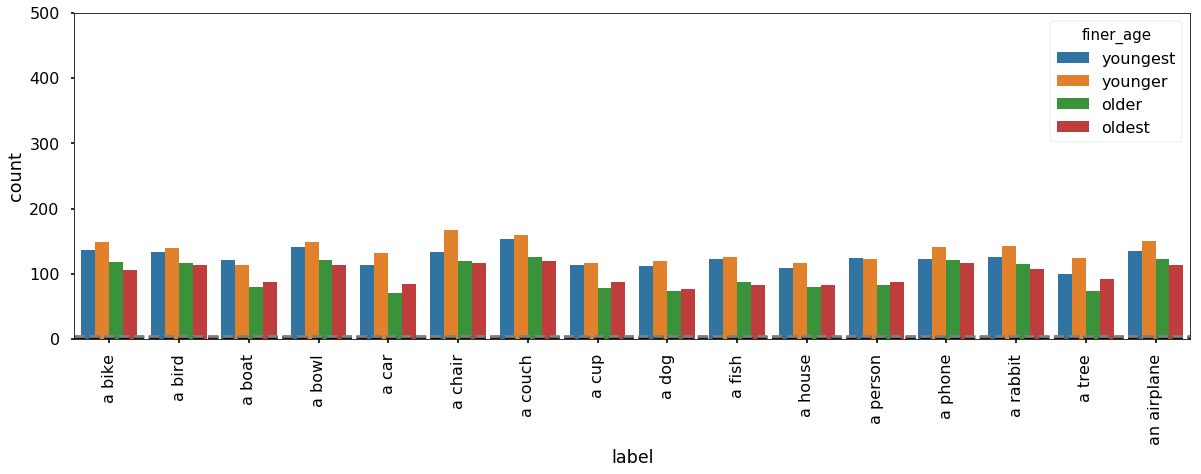

In [18]:
sns.set_context('poster')
plt.figure(figsize=(20,6))
sns.countplot(data=KM,
           x='label',
           hue='finer_age')
labels = np.unique(KM.label.values)
h = plt.xticks(range(len(labels)), labels, fontsize=16,rotation='vertical')
plt.axhline(3,linestyle='dashed',color='black')
plt.axhline(5,linestyle='dashed',color='gray')
plt.ylim(0,500)
if not os.path.exists('./plots'):
    os.makedirs('./plots')
plt.savefig('./plots/drawing_counts_by_label_and_finer_age.pdf', bbox_inches="tight")

### Define subfunctions relevant for calculating RDMs and dprime metrics

In [151]:
# Gets mean of each class (e.g., category) in a feature space
def get_class_means_bl(F, M):  # just adapted to take in features and metadata directly  
    X = F;
    labels = M.label.values
    _mu = np.zeros((len(np.unique(labels)), np.shape(X)[1]))        
    for vi, v in enumerate(np.unique(np.asarray(labels))):
        Xv = X[labels == v]
        nv = float(Xv.shape[0])
        if nv > 0:
            _mu[vi] = Xv.mean(0)
    return _mu

# Gets "std" of each class (e.g., category) in a feature space
def get_class_std(F,M,this_label):    
    class_features = F[M.label.values==this_label]
    class_mean = class_features.mean(0); # mean ovver rows, i.e. images
    num_images = np.shape(class_features)[0] # number of images for this class in this set
    # open variables
    _dist = np.zeros(num_images)   
    _dist_sq = np.zeros(num_images) 
    # for each image, get distance to category mean and square it
    for vi in range(num_images): 
        _dist[vi] = distance.euclidean(class_features[vi],class_mean) ## get euclidean distance to mean
        _dist_sq[vi] = _dist[vi]**2 # square each distance
    dist_sum = sum(_dist_sq) / num_images; # sum these distances and divide by the number of IMAGES
    return np.sqrt(dist_sum) #  get square root to make it a std (RMSE)

# Use mean and std to compute a higher-dimensional d-prime matrix
def get_class_dprime(class_std, class_means,ordered_objs):
    d_prime = np.zeros((len(np.unique(ordered_objs)), len(np.unique(ordered_objs)))); # n-class x n-class matrix      
    for i, v in enumerate(ordered_objs): # go through each list of classes
        for i2, v2 in enumerate(ordered_objs): # and each pair of classes
            if i==i2: # if we're in the diagonal
                d_prime[i,i2] = 0; # give dummy value when looking at same category, 0 = the same category
            else:
                sd1=class_std[i]; sd2=class_std[i2]; # grab class variance for each pair of categories
                m1=class_means[i];  m2=class_means[i2]; # grab class means for each pair of categories
                num = distance.euclidean(m1,m2) # distance between two mean vectors
                denom = np.sqrt(.5*(sd1**2+sd2**2)); # calculate denominator 
                d=num/denom;
                d_prime[i,i2] = d;  # fill in matrix
    return d_prime;

### Get sorting indexes for plotting dprimes and RDMs

In [177]:
_labels = np.unique(KM.label.values)
ordered_objs = ['an airplane', 'a bike', 'a car', 'a boat', 'a chair', 'a couch', 'a house', 'a cup', 'a bowl', 'a phone', 'a person', 'a bird', 'a dog', 'a fish', 'a rabbit', 'a tree']
ordered_objs = np.asarray(ordered_objs)
sort_inds = [np.where(_labels==ordered_objs[i])[0][0] for i in np.arange(len(ordered_objs))]

### Calculate dprime in each age group

In [178]:
dim=16
class_list = np.asarray(np.unique(KM.label.values))
dprime_by_age = np.zeros([np.shape(class_list)[0], np.shape(class_list)[0], np.shape(range(2,11))[0]])
dprime_avg_by_age = np.zeros(np.shape(range(2,11)))

for age in range(2,11):
#     print age
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]
    print 'We have {} {}-year olds who contributed {} drawings'.format(np.shape(np.unique(KM_subset['session']))[0],age, np.shape(KM_subset)[0])
    class_means = np.zeros(np.shape(class_list)[0])
    class_std = np.zeros(np.shape(class_list)[0]) 
    #
    class_means = get_class_means_bl(KF_subset, KM_subset)
    ordered_means = class_means[sort_inds,:] # order these in same order!! 

    agei = age-2
    for l, this_label in enumerate(ordered_objs): # goes through ordered list
        class_std[l] = get_class_std(KF_subset,KM_subset,this_label)
    dprime_this_age = get_class_dprime(class_std, ordered_means, ordered_objs)
    dprime_by_age[:,:,agei] = dprime_this_age
    dprime_avg_by_age[agei] = np.mean(np.ravel(dprime_this_age[np.triu_indices(dim,k=1)]))

We have 207 2-year olds who contributed 729 drawings
We have 271 3-year olds who contributed 1266 drawings
We have 218 4-year olds who contributed 1049 drawings
We have 196 5-year olds who contributed 1115 drawings
We have 161 6-year olds who contributed 933 drawings
We have 113 7-year olds who contributed 649 drawings
We have 108 8-year olds who contributed 582 drawings
We have 68 9-year olds who contributed 409 drawings
We have 105 10-year olds who contributed 594 drawings


### Output average d-prime stats across category pairings

In [215]:
round(np.max(dprime_avg_by_age[agei]),2)

0.51

In [217]:
dim = 16
for agei in range(0,9):
    print 'average d prime of {} year old = {} '.format(agei+2, np.round(dprime_avg_by_age[agei],2))
    print 'max d prime of {} year old = {} '.format(agei+2,round(np.max(dprime_by_age[agei]),2))
#     print ' {}-yrs, M={}'.format(agei+2, np.round(dprime_avg_by_age[agei],2))

average d prime of 2 year old = 0.3 
max d prime of 2 year old = 0.64 
average d prime of 3 year old = 0.27 
max d prime of 3 year old = 0.76 
average d prime of 4 year old = 0.35 
max d prime of 4 year old = 0.74 
average d prime of 5 year old = 0.42 
max d prime of 5 year old = 0.68 
average d prime of 6 year old = 0.45 
max d prime of 6 year old = 0.79 
average d prime of 7 year old = 0.49 
max d prime of 7 year old = 0.65 
average d prime of 8 year old = 0.49 
max d prime of 8 year old = 0.83 
average d prime of 9 year old = 0.51 
max d prime of 9 year old = 0.63 
average d prime of 10 year old = 0.48 
max d prime of 10 year old = 0.69 


### Quick plot of average dprime x age with std as errorbars 

In [185]:
# Quick plot of average dprime x age with std as 
# vals_to_avg = (dprime_by_age[np.triu_indices(dim,k=1)])
# dprime_age_means = np.mean(vals_to_avg,0)
# dprime_age_stds = np.std(vals_to_avg,0)
# matplotlib.pyplot.errorbar(np.arange(2,11), dprime_age_means, yerr = dprime_age_stds )

### Define a set of plotting functions for dprime/RDM

In [218]:
def show_dprime(d_prime,ordered_objs,age):
    sns.set_context('paper')
    fig = plt.figure(figsize=(40,40))
    plt.matshow(d_prime, vmin=0, vmax=.8) # maximum pairwise value in data
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90,fontsize = 16);
    plt.yticks(range(len(ordered_objs)), ordered_objs,fontsize = 16); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False 
    plt.savefig('./plots/Dprime_{}_Layer_{}.pdf'.format(age, layer_ind), bbox_inches="tight")

def showRDM(RDM,ordered_objs,age):
    sns.set_context('paper')
    fig = plt.figure(figsize=(30,30))
    plt.matshow(RDM, vmin=0, vmax=2)
    plt.xticks(range(len(ordered_objs)), ordered_objs, rotation=90);
    plt.yticks(range(len(ordered_objs)), ordered_objs); 
    plt.colorbar()
    for tick in pylab.gca().xaxis.iter_ticks():
        tick[0].label2On = True
        tick[0].label1On = False
        tick[0].label2.set_rotation('vertical')
        tick[0].tick1On = False
        tick[0].tick2On = False
    for tick in pylab.gca().yaxis.iter_ticks():
        tick[0].tick1On = False
        tick[0].tick2On = False  
    plt.savefig('./plots/RDM_{}_Layer_{}.pdf'.format(age, layer_ind), bbox_inches="tight")

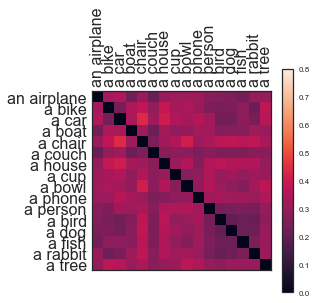

In [219]:
show_dprime(dprime_by_age[:,:,0],ordered_objs,'age2')

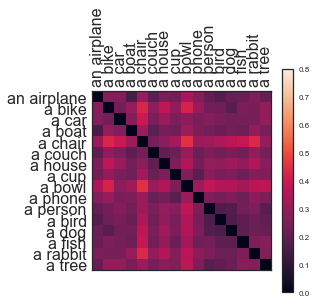

In [220]:
show_dprime(dprime_by_age[:,:,1],ordered_objs,'age3')

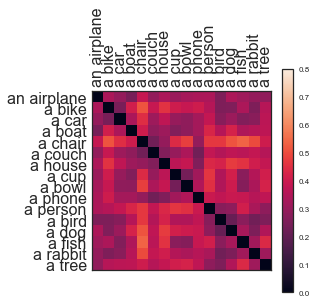

In [221]:
show_dprime(dprime_by_age[:,:,2],ordered_objs,'age4')

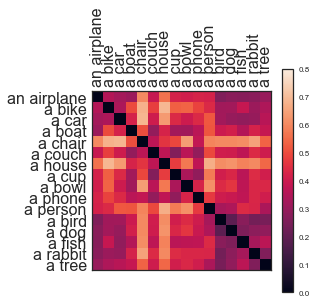

In [222]:
show_dprime(dprime_by_age[:,:,3],ordered_objs,'age5')

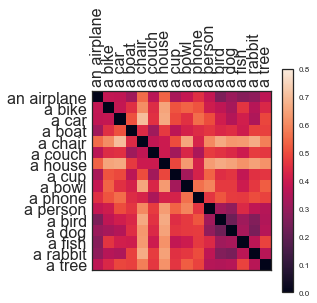

In [223]:
show_dprime(dprime_by_age[:,:,4],ordered_objs,'age6')

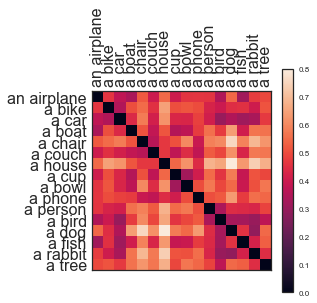

In [224]:
show_dprime(dprime_by_age[:,:,5],ordered_objs,'age7')

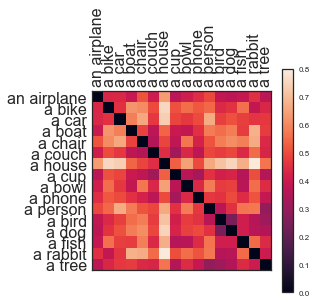

In [225]:
show_dprime(dprime_by_age[:,:,6],ordered_objs,'age8')

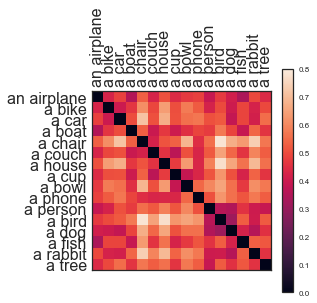

In [226]:
show_dprime(dprime_by_age[:,:,7],ordered_objs,'age9')

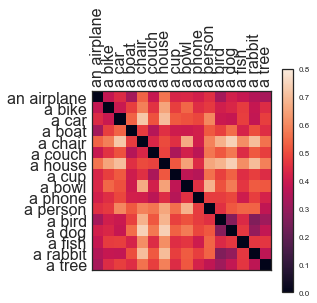

In [227]:
show_dprime(dprime_by_age[:,:,8],ordered_objs,'age10')

In [208]:
rdm_by_age = np.zeros([np.shape(class_list)[0], np.shape(class_list)[0], np.shape(range(2,11))[0]])
rdm_corr_age = np.zeros(np.shape(range(10,2,-1))[0])

for age in range(10,1,-1):
    agei = age-2
    ind = KM.index[KM['age'] == age]
    KM_subset =  KM.loc[ind]
    KF_subset =  KF[ind.tolist()]

    class_means = np.zeros(np.shape(class_list)[0])
    class_means = get_class_means_bl(KF_subset, KM_subset)
    ordered_means = class_means[sort_inds,:]
    this_rdm = np.corrcoef(ordered_means)
    this_rdm = 1 - this_rdm
    if age==10:
        oldest_rdm = this_rdm
    else:
        rdm_by_age[:,:,agei] = this_rdm
        rdm_corr_age[agei] = stats.spearmanr(np.ravel(oldest_rdm[np.triu_indices(16,k=1)]),np.ravel(this_rdm[np.triu_indices(16,k=1)]))[0]
        print 'rdm corr for age {} is {}'.format(age, rdm_corr_age[agei])

rdm corr for age 9 is 0.897937356761
rdm corr for age 8 is 0.90072227238
rdm corr for age 7 is 0.890985485103
rdm corr for age 6 is 0.918681852906
rdm corr for age 5 is 0.916924786444
rdm corr for age 4 is 0.816320577818
rdm corr for age 3 is 0.733030071533
rdm corr for age 2 is 0.615820543093


In [210]:
for age in range(2,10,1):
    agei=age-2
    print ' {}-yrs, r={}'.format(age, np.round(rdm_corr_age[agei],2))

 2-yrs, r=0.62
 3-yrs, r=0.73
 4-yrs, r=0.82
 5-yrs, r=0.92
 6-yrs, r=0.92
 7-yrs, r=0.89
 8-yrs, r=0.9
 9-yrs, r=0.9


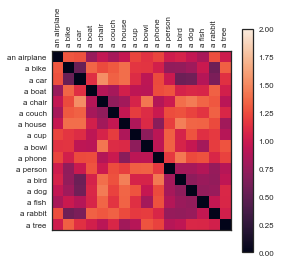

In [382]:
showRDM(rdm_by_age[:,:,0],ordered_objs,'age2')


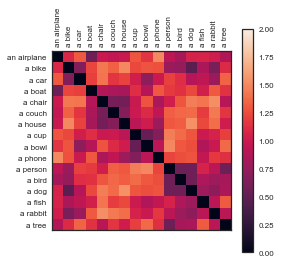

In [383]:
showRDM(rdm_by_age[:,:,1],ordered_objs,'age3')

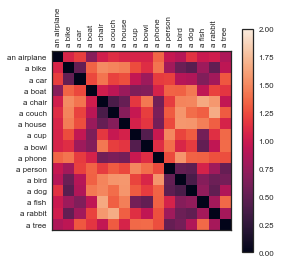

In [384]:
showRDM(rdm_by_age[:,:,2],ordered_objs,'age4')

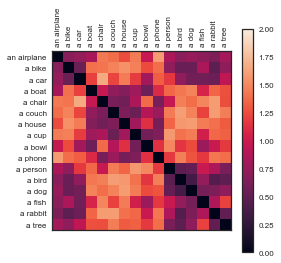

In [385]:
showRDM(rdm_by_age[:,:,3],ordered_objs,'age5')


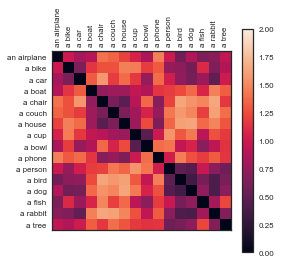

In [386]:
showRDM(rdm_by_age[:,:,4],ordered_objs,'age6')


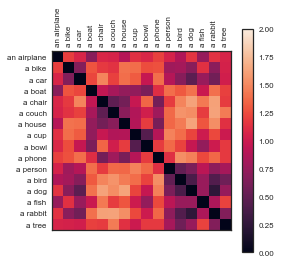

In [387]:
showRDM(rdm_by_age[:,:,5],ordered_objs,'age7')


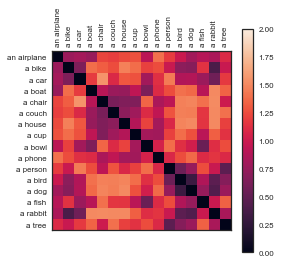

In [388]:
showRDM(rdm_by_age[:,:,6],ordered_objs,'age8')


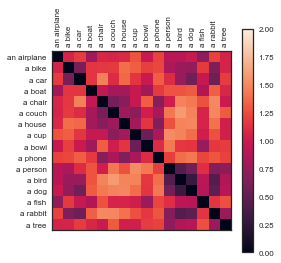

In [389]:
showRDM(rdm_by_age[:,:,7],ordered_objs,'age9')

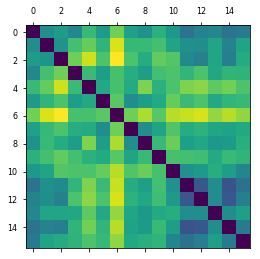

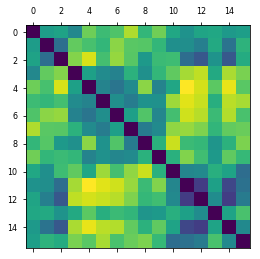

In [119]:
euc_distance = distance.pdist(ordered_means)
matrix = distance.squareform(euc_distance)
plt.matshow(matrix)

corr_distance = distance.pdist(ordered_means, metric="correlation")
matrix2 = distance.squareform(corr_distance)
plt.matshow(matrix2)

In [120]:
euc_distance

array([ 24.74845558,  27.78174074,  23.25233295,  33.85480935,
        27.03724952,  39.54216392,  28.80408751,  25.81348729,
        31.97696459,  26.69206525,  19.02852083,  22.60959258,
        23.37577979,  19.23495551,  20.95068012,  26.02284229,
        35.28499175,  38.33964013,  32.73699856,  47.45318677,
        33.52616582,  33.863308  ,  35.39250268,  29.30802194,
        25.11306608,  24.90213943,  29.77375194,  22.3283876 ,
        29.28203395,  39.07985712,  46.52785504,  36.05113521,
        50.16300771,  35.87036535,  31.05795625,  38.20958375,
        36.68431055,  23.75703504,  21.83468888,  29.49547267,
        21.54056135,  30.92452149,  34.23657789,  27.84728967,
        35.61941596,  31.21712778,  27.98047315,  35.16654224,
        36.21628494,  33.0202316 ,  36.04949494,  29.89447308,
        32.84681749,  32.61119784,  30.36960965,  35.4749863 ,
        30.92023589,  40.46439935,  32.1088331 ,  35.90604616,
        40.38063599,  41.51330795,  37.67333176,  39.42